In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# basic functions

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def catTriangle(w,l):
    return int(math.factorial(w+l)*(w+-l+1)/(math.factorial(l)*math.factorial(w+1)))

def catTrapezoid(w,l,m):
    if 0 <= l < m:
        return nCr(w + l, l)
    elif m <= l <= w + m -1:
        return nCr(w+l,l) - nCr(w+l,l-m)
    else:
        return 0

dp = {}
def catTrapezoidWeighted(w,l,m,a,b):
    f = (w,l,m,a,b)
    if f in dp:
        return dp[f]
    if l == 0:
        return 1
    elif b*l >= a*w + m:
        return 0
    elif w == 0:
        return 1
    else:
        val = catTrapezoidWeighted(w-1,l,m,a,b) + catTrapezoidWeighted(w,l-1,m,a,b)
        dp[f] = val
        return dp[f]
    
dp2 = {}
def catTrapezoidWeightedInverse(x,w,l,p,q,c):
    f = (x,w,l,p,q,c)
    if f in dp2:
        return dp2[f]
    else:
        x_new = x_update(x,w,l,p,q)
        if local_reward(x_new,p,q,c) < 0:
            dp2[f] = 0
            return dp2[f]
        elif w == 0 and l == 0:
            dp2[f] = 1
            return dp2[f]
        elif l == 0:
            dp2[f] = catTrapezoidWeightedInverse(x,w-1,l,p,q,c)
            return dp2[f]
        elif w == 0:
            dp2[f] = catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            return dp2[f]
        else:
            dp2[f] = catTrapezoidWeightedInverse(x,w-1,l,p,q,c) + catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            return dp2[f]

def getAB(p,q,x):
    a = math.log(p/q)
    b = math.log((1-q)/(1-p))

    return (a/b).as_integer_ratio()
        
def update_prior(x,p,q,result):
    if result == True:
        return p*x/(win(x,p,q))
    else:
        return (1 - p)*x/(lose(x,p,q))

def prior_inverse(x,p,q,result):
    if result == True:
        return x*q/(p - x*p + x*q)
    else:
        return x*(1-q)/( (1-p) - x*(1-p) + x*(1-q))

def local_reward(x,p,q,c):
    out = win(x,p,q) - c
    return out

def win(x,p,q):
    return x*p + (1-x)*q

def lose(x,p,q):
    return x*(1-p) + (1-x)*(1-q)

def x_update(x,w,l,p,q):
    return  (x*p**w*(1-p)**l)/(x*p**w*(1-p)**l + (1-x)*q**w*(1-q)**l)

def expected_profit(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while local_reward(x_new,p,q,c) >= 0 and possibleLosses < 40:
        possibleLosses += 1
#         print(x_new, local_reward(x_new,p,q,c))
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2)-1)
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 print('got here')
                tot += delta**t*(win(x,p,q) - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot

def expected_profit_weighted(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0
    
    tot = 0

    for t in range(rounds):
        lowest = 0
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoidWeightedInverse(x,w,l,p,q,c)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoidWeightedInverse(x,w,l-1,p,q,c) > 0: # final loss
#                 print('got here',delta**t*(c - c2)*catTrapezoidWeightedInverse(x,w,l-1,p,q,c)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q))
                tot += delta**t*(c - c2)*catTrapezoidWeightedInverse(x,w,l-1,p,q,c)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
    return tot

# dynamic pricing

def dynamic_profit(x,x2,p,q,c2,delta,rounds=100):
    
    tot = 0
    if c2 > p:
        return 0
    if c2 < q:
        x2 = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while (x_new >= x2) and possibleLosses < 40:
        possibleLosses += 1
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
#     print(possibleLosses)
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2)-1)
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(win(x,p,q) - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 print ('got here')
                tot += delta**t*(win(x,p,q) - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot

def prob_reach(x,w,l,p,q):
    prob = 1
    for i in range(w):
        prob *= win(x,p,q)
        x = update_prior(x,p,q,True)
    for i in range(l):
        prob *= lose(x,p,q)
        x = update_prior(x,p,q,False)
    return prob

def getPossibleCX(x,p,q,c):
    # todo: add c2
    # returns the possible static prices such that local reward > 0
    if local_reward(x,p,q,c) < 0:
        return []
    elif x == 1:
        return []
    else:
        kList = []
        possible = True
        k = 0
        while possible: # todo if c < q then forever
            if local_reward(x,p,q,c) <= 0 or k > 30:
                possible = False
            k += 1
            c2 = win(x,p,q)
            kList.append(c2)
            x = update_prior(x,p,q,False)
        return kList

1.967323841021222
0.7520886990352598


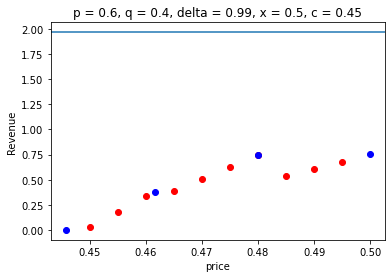

In [14]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.45
delta = 0.99

# plot
# prices = getPossibleCX(x,p,q,c2)
start = 0.45
prices = [start + 0.005*i for i in range(10)]
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
#     print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')

prices = getPossibleCX(x,p,q,c2)
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
#     print(prices[i],ep)
    profits.append(ep)

y = dynamic_profit(x,0.15,p,q,c2,delta)    
print(y)
print(max(profits))
    
plt.plot(prices,profits,'bo')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.axhline(y=y,label='test')
# plt.text(10.1,0,'blah',rotation=90)
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}, c = {c2}')
plt.show()


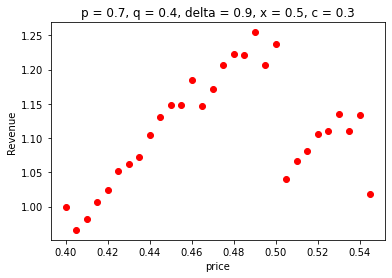

In [13]:
x = 0.5
p = 0.7
q = 0.4
# c = 0.40001
c2 = 0.3
delta = 0.9

# plot
# prices = getPossibleCX(x,p,q,c2)
prices = [0.4 + 0.005*i for i in range(30)]
profits = []
for i in range(len(prices)):
    ep = expected_profit_weighted(x,p,q,prices[i],c2,delta)
#     print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}, c = {c2}')
plt.show()

In [80]:
def get_best_static_price(x,p,q,c2,delta):
    prices = getPossibleCX(x,p,q,c2)
    prior = None
    bestProfit = 0
    losses = None
    for i in range(len(prices)):
        profit,possibleLosses = expected_profit_rounds(x,p,q,prices[i],c2,delta)
        print(prices[i],profit,possibleLosses)
        if profit >= bestProfit:
            prior = x
            for j in range(i):
                prior = update_prior(prior,p,q,False)
            bestProfit = profit
            losses = possibleLosses
    return prior, bestProfit, losses

def expected_profit_rounds(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0,0
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while local_reward(x_new,p,q,c) >= 0 and possibleLosses < 40:
        possibleLosses += 1
#         print(x_new, local_reward(x_new,p,q,c))
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2)-1)
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
#             print(f"t: {t}, w: {w}, l: {l}, paths: {paths}")
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
            elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 print('got here')
                tot += delta**t*(win(x,p,q) - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot, possibleLosses



In [81]:
get_best_static_price(0.565,0.6,0.4,0.45,0.9)

0.513 0.29224570679417733 0
0.4928131416837782 0.29319558292597864 1
0.47319838056680164 0.19174267241947843 2
0.45557946510913006 0.05693651079587213 3
0.44083568605307744 0 0


(0.46406570841889117, 0.29319558292597864, 1)

In [71]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
# c2 = 0.45
delta = 0.9

production_prices = [0.4 + 0.005*i for i in range(20)]
revs = []
x_mins = []
for c2 in production_prices:
    x_min, rev, losses = get_best_static_price(x,p,q,c2,delta)
    revs.append(rev)
    
    for i in range(losses):
        x_min = update_prior(x_min,p,q,False)
    x_mins.append(x_min)
    
#     print(c2,x,rev,x_min,losses)
    
print(production_prices,x_mins)

[0.4, 0.405, 0.41000000000000003, 0.41500000000000004, 0.42000000000000004, 0.42500000000000004, 0.43000000000000005, 0.43500000000000005, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47000000000000003, 0.47500000000000003, 0.48000000000000004, 0.48500000000000004, 0.49, 0.495] [0.30769230769230776, 0.30769230769230776, 0.30769230769230776, 0.30769230769230776, 0.30769230769230776, 0.30769230769230776, 0.30769230769230776, 0.30769230769230776, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


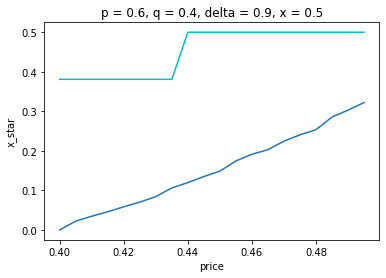

In [9]:
x_stars_dynamic = [0,0.0222,0.0346,0.046,0.05845,0.07025,0.0843,0.106075,0.119725,0.134925,
                   0.148725,0.1744875,0.1914375,0.2029,0.22465,0.2405375,0.253525,0.2855625,
                   0.30295,0.3222375]

plt.plot(production_prices,x_stars_dynamic)
plt.plot(production_prices,x_mins,'c')
plt.xlabel('price')
plt.ylabel('x_star')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}')
plt.show()

0.5 0.38095238095238093 0.0222
0.5 0.38095238095238093 0.0346
0.5 0.38095238095238093 0.046
0.5 0.38095238095238093 0.05845
0.5 0.38095238095238093 0.07025
0.5 0.38095238095238093 0.0843
0.5 0.38095238095238093 0.106075
0.5 0.5 0.119725
0.5 0.5 0.134925
0.5 0.5 0.148725
0.5 0.5 0.1744875
0.5 0.5 0.1914375
0.5 0.5 0.2029
0.5 0.5 0.22465
0.5 0.5 0.2405375
0.5 0.5 0.253525
0.5 0.5 0.2855625
0.5 0.5 0.30295
0.5 0.5 0.3222375
[27.104643104643102, 17.170297910182306, 12.762541806020067, 9.913009146542079, 8.144538735286066, 6.684551510174287, 5.186025852535398, 7.352474420547088, 6.411524921252548, 5.723819129265423, 4.731069560856795, 4.223636957231472, 3.9285362247412516, 3.4513687959047408, 3.157355921633841, 2.944384183019426, 2.5018603633180128, 2.300874731803928, 2.103301136584041]


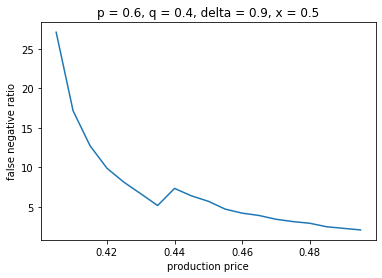

In [10]:
play_forever_ratio = []
false_negative_ratio = []
for i in range(1,len(production_prices)):
    print(x,x_mins[i],x_stars_dynamic[i])
#     r = (x - x_mins[i])/((x - x_mins[i])*x)
#     play_forever_ratio.append(r)
    
    r2 = (1/x_stars_dynamic[i]-1)/(1/x_mins[i]-1)
    false_negative_ratio.append(r2)
    
print(false_negative_ratio)

plt.plot(production_prices[1:],false_negative_ratio)
plt.xlabel('production price')
plt.ylabel('false negative ratio')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}')
plt.show()

In [55]:
# computed from other file
x_stars_045 = [0.1951, 0.1984, 0.2015, 0.2048, 0.1491, 0.1515, 0.1542, 0.1569,
 0.1595, 0.1622, 0.165, 0.1677, 0.1705, 0.1734, 0.1763, 0.1793, 0.182, 0.1852,
 0.1882, 0.1913, 0.1946, 0.1976, 0.2008, 0.2042, 0.1486, 0.1511, 0.1538, 0.1565,
 0.1594, 0.162, 0.165, 0.1678, 0.1707, 0.1738, 0.1767, 0.1799, 0.1832, 0.1864,
 0.1897, 0.1931, 0.1965, 0.2001, 0.2036, 0.1484, 0.1511, 0.1542, 0.1573, 0.1603,
 0.1635, 0.1667, 0.1701, 0.1734, 0.1767, 0.1805, 0.1842, 0.188, 0.1919, 0.1959,
 0.1999, 0.2042, 0.1495, 0.1529, 0.1563, 0.1602, 0.1639, 0.1677, 0.1719, 0.1759,
 0.1805, 0.1849, 0.1897, 0.1947, 0.1997, 0.205, 0.1509, 0.1553, 0.1602, 0.165,
 0.1701, 0.1754, 0.181, 0.1871, 0.1934, 0.2001, 0.1483, 0.1538, 0.1602, 0.1667,
 0.1739, 0.1815, 0.1896, 0.1987, 0.1492, 0.1573, 0.1662, 0.1763, 0.1873, 0.1997,
 0.1533, 0.1657, 0.1799, 0.1972, 0.156, 0.1751, 0.1997, 0.1671, 0.2012, 0.1839,
 0.1846, 0.1846]

x_stars_041 = [0.0391, 0.0398, 0.0407, 0.0414, 0.0423, 0.0432, 0.044, 0.0449, 0.0456,
 0.0467, 0.0474, 0.0484, 0.0494, 0.034, 0.0348, 0.0356, 0.0362, 0.0367, 0.0376, 0.0384,
 0.0389, 0.0398, 0.0405, 0.0414, 0.0421, 0.043, 0.0438, 0.0446, 0.0455, 0.0464, 0.0472,
 0.0483, 0.0491, 0.034, 0.0347, 0.0353, 0.0362, 0.0367, 0.0376, 0.0384, 0.0391, 0.04,
 0.0407, 0.0416, 0.0424, 0.0433, 0.0442, 0.0451, 0.0459, 0.0471, 0.0481, 0.0491, 0.034,
 0.0348, 0.0356, 0.0363, 0.037, 0.0381, 0.0389, 0.0398, 0.0407, 0.0416, 0.0427, 0.0438,
 0.0449, 0.0459, 0.0471, 0.0483, 0.0496, 0.0345, 0.0353, 0.0363, 0.0373, 0.0384, 0.0394,
 0.0405, 0.0416, 0.0429, 0.0442, 0.0455, 0.047, 0.0486, 0.034, 0.0351, 0.0363, 0.0376,
 0.0389, 0.0403, 0.0419, 0.0435, 0.0452, 0.0471, 0.049, 0.0347, 0.0363, 0.0381, 0.04,
 0.0419, 0.0442, 0.0467, 0.0494, 0.0356, 0.0379, 0.0405, 0.0435, 0.047, 0.0345, 0.0378, 0.0416]

In [72]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.45
delta = 0.9

priors = [c2 + 0.005*i for i in range(109)]
revs = []
x_mins = []
for x in priors:
    x_min, rev, losses = get_best_static_price(x,p,q,c2,delta)
    print(x,x_min,losses)
    revs.append(rev)
    x_mins.append(x_min)
    
    
# print(priors,x_mins)

0.45 0.45 0
0.455 0.455 0
0.46 0.46 0
0.465 0.465 0
0.47000000000000003 0.47000000000000003 0
0.47500000000000003 0.47500000000000003 0
0.48 0.48 0
0.485 0.485 0
0.49 0.49 0
0.495 0.495 0
0.5 0.5 0
0.505 0.505 0
0.51 0.51 0
0.515 0.515 0
0.52 0.52 0
0.525 0.525 0
0.53 0.53 0
0.535 0.535 0
0.54 0.54 0
0.545 0.545 0
0.55 0.55 0
0.555 0.555 0
0.56 0.56 0
0.5650000000000001 0.4640657084188913 1
0.5700000000000001 0.4691358024691359 1
0.575 0.4742268041237113 1
0.5800000000000001 0.4793388429752067 1
0.585 0.48447204968944096 1
0.5900000000000001 0.4896265560165976 1
0.595 0.4948024948024948 1
0.6 0.5 1
0.605 0.5052192066805845 1
0.61 0.5104602510460251 1
0.615 0.5157232704402516 1
0.62 0.5210084033613446 1
0.625 0.5263157894736842 1
0.63 0.5316455696202532 1
0.635 0.5369978858350952 1
0.64 0.5423728813559322 1
0.645 0.5477707006369428 1
0.65 0.5531914893617021 1
0.655 0.5586353944562901 1
0.66 0.5641025641025642 1
0.665 0.5695931477516061 1
0.67 0.5751072961373391 1
0.675 0.580645161290322

0.45 0.45 0.148725
0.455 0.455 0.148725
0.46 0.46 0.148725
0.465 0.465 0.148725
0.47000000000000003 0.47000000000000003 0.148725
0.47500000000000003 0.47500000000000003 0.148725
0.48 0.48 0.148725
0.485 0.485 0.148725
0.49 0.49 0.148725
0.495 0.495 0.148725
0.5 0.5 0.148725
0.505 0.505 0.148725
0.51 0.51 0.148725
0.515 0.515 0.148725
0.52 0.52 0.148725
0.525 0.525 0.148725
0.53 0.53 0.148725
0.535 0.535 0.148725
0.54 0.54 0.148725
0.545 0.545 0.148725
0.55 0.55 0.148725
0.555 0.555 0.148725
0.56 0.56 0.148725
0.5650000000000001 0.4640657084188913 0.148725
0.5700000000000001 0.4691358024691359 0.148725
0.575 0.4742268041237113 0.148725
0.5800000000000001 0.4793388429752067 0.148725
0.585 0.48447204968944096 0.148725
0.5900000000000001 0.4896265560165976 0.148725
0.595 0.4948024948024948 0.148725
0.6 0.5 0.148725
0.605 0.5052192066805845 0.148725
0.61 0.5104602510460251 0.148725
0.615 0.5157232704402516 0.148725
0.62 0.5210084033613446 0.148725
0.625 0.5263157894736842 0.148725
0.63 0.53

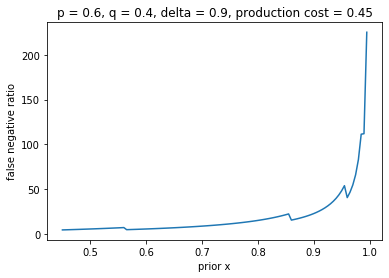

In [47]:
fixed_x_star = x_stars_dynamic[10]
false_negative_ratio = []
for i in range(len(priors)):
    print(priors[i],x_mins[i],fixed_x_star)
#     r = (x - x_mins[i])/((x - x_mins[i])*x)
#     play_forever_ratio.append(r)
    
    r2 = (1/fixed_x_star-1)/(1/x_mins[i]-1)
    false_negative_ratio.append(r2)
    
print(false_negative_ratio)

plt.plot(priors,false_negative_ratio)
plt.xlabel('prior x')
plt.ylabel('false negative ratio')
plt.title(f'p = {p}, q = {q}, delta = {delta}, production cost = {c2}')
plt.show()

0.45 0.45 0.1951 3.3754717860304737
0.455 0.455 0.1984 3.373113347144126
0.46 0.46 0.2015 3.3757007627975373
0.465 0.465 0.2048 3.3747809579439254
0.47000000000000003 0.47000000000000003 0.1491 5.060843045695557
0.47500000000000003 0.47500000000000003 0.1515 5.0672638692440675
0.48 0.48 0.1542 5.063154744088596
0.485 0.485 0.1569 5.060467677761482
0.49 0.49 0.1595 5.062941791136517
0.495 0.495 0.1622 5.062946368619598
0.5 0.5 0.165 5.0606060606060606
0.505 0.505 0.1677 5.063292435385459
0.51 0.51 0.1705 5.063678257226644
0.515 0.515 0.1734 5.061879451598711
0.52 0.52 0.1763 5.061495556816034
0.525 0.525 0.1793 5.059060087474683
0.53 0.53 0.182 5.068272153378538
0.535 0.535 0.1852 5.061868598899185
0.54 0.54 0.1882 5.063669546735666
0.545 0.545 0.1913 5.063578867551685
0.55 0.55 0.1946 5.058467511704922
0.555 0.555 0.1976 5.064504389755721
0.56 0.56 0.2008 5.065555957986238
0.5650000000000001 0.4640657084188913 0.2042 3.374552031852178
0.5700000000000001 0.4691358024691359 0.1486 5.0632

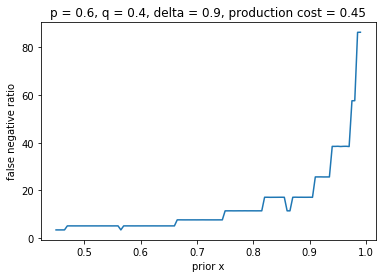

In [87]:
play_forever_ratio = []
false_negative_ratio = []
for i in range(len(priors)):
    r = (x_mins[i]*(1 - x_stars_045[i]) -1 )/(x_stars_045[i]*(1 - x_mins[i]) -1 )
    play_forever_ratio.append(r)
    
    r2 = (1/x_stars_045[i]-1)/(1/x_mins[i]-1)
    
    print(priors[i],x_mins[i],x_stars_045[i],r2)
    false_negative_ratio.append(r2)
    
print(false_negative_ratio)

plt.plot(priors,false_negative_ratio)
plt.xlabel('prior x')
plt.ylabel('false negative ratio')
plt.title(f'p = {p}, q = {q}, delta = {delta}, production cost = {c2}')
plt.show()

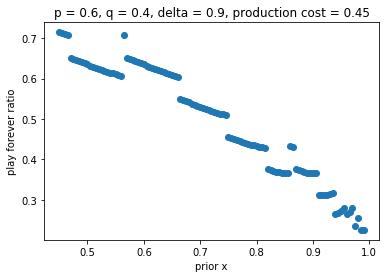

In [88]:
plt.plot(priors,play_forever_ratio, 'o')
plt.xlabel('prior x')
plt.ylabel('play forever ratio')
plt.title(f'p = {p}, q = {q}, delta = {delta}, production cost = {c2}')
plt.show()